In [80]:
%matplotlib inline
import numpy as np

from astropy import units as u
from astropy.io import fits
import aplpy
from astropy.constants import c

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'Helvetica','sans-serif':['Helvetica']}) 
rc('text', usetex=True)

## Calculate mass for Barnard 5 using SCUBA2 850𝜇m and 450𝜇m maps 

Assuming optically thin emission, 
$$M_{dust}=
\frac{d^2\,F_\nu}{\kappa_\nu B_\nu(T)} = 
0.12M_\odot \left( e^{1.439(\textrm{mm}/\lambda)(10\textrm{K}/T)}-1 \right)
\left( \frac{\kappa_\nu}{0.01 \textrm{cm}^2 \textrm{g}^{-1}} \right)^{-1}
\left( \frac{S_\nu}{ \textrm{Jy}} \right)
\left( \frac{D}{100 \textrm{pc}} \right)^2
\left( \frac{\lambda}{\textrm{mm}} \right)^3\\
M_{450}=0.53 M_\odot \left( \frac{S_\nu}{ \textrm{Jy}} \right)\\
M_{850}=2.4 M_\odot \left( \frac{S_\nu}{ \textrm{Jy}} \right)~,$$
where $d$ is the distance, $F_\nu$ is the total flux, $\kappa_{\nu}$ is the dust opacity 
per unit mass at frequency $\nu$, and 
$B_\nu(T)$ is the Planck function at temperature $T$. 
We use a dust to gas ratio of 0.01, and a dust opacity per unit mass of 
$\kappa_\nu = 0.1\,(\nu/1\,\textrm{THz})^2$, which at 450$\mu$m and 850$\mu$m give
$\kappa_{450\mu\textrm{m}}=0.044\textrm{cm}^2\textrm{g}^{-1}$ and 
$\kappa_{850\mu\textrm{m}}=0.012\textrm{cm}^2\textrm{g}^{-1}$, respectively. 
We assume a temperature of T=10\,K, which is the typical temperature of starless cores in Perseus, and distance of 302\,pc.

On the other hand, using the column density maps from Herschel, then we can calculate the total mass as 
$$
M_{Herschel} = \sum N({\rm H_2}) A_{pixel} \mu m_H~,
$$
where $\mu=2.8$ is the mean molecular weight, and $A_{pixel}$ is the pixel area. The pixel area is determined as 
$$
A_{pixel} = (\Delta x)(\Delta y) d^2~,
$$
where $\Delta x$ and $\Delta y$ are the pixel size in radians, and $d$ is the distance.

In [81]:
def mass_dust(Flux=1*u.Jy, kappa_nu=0.01*u.cm**2/u.g, Td=10*u.K, distance=100*u.pc, wavelength=1*u.mm):
    """
    """
    M = 0.12*u.Msun * (np.exp(1.439*u.mm/wavelength*10*u.K/Td) - 1) * (0.01*u.cm**2/u.g / kappa_nu) * (Flux / u.Jy)\
        * (distance / (100*u.pc))**2 * (wavelength / u.mm)**3
    return M.to(u.Msun)


def kappa_law(wavelength=1*u.mm):
    """
    """
    nu = (c/wavelength).to(u.THz)
    return 0.1*u.cm**2/u.g * (nu / u.THz)**2


def Ncol_to_mass(Ntotal=3e24*u.cm**-2, distance=300*u.pc, pixsize=1*u.arcsec):
    """
    """
    Area = (pixsize.to('', equivalencies=u.dimensionless_angles())*distance)**2
    return (Ntotal * Area * 2.8 * u.u).to(u.Msun)


def density(Mass=1*u.Msun, radius=0.1*u.pc):
    """
    """
    return (Mass / (4/3. * np.pi * radius**3) / (2.8 * u.u)).to(1e4*u.cm**-3)

In [82]:
# N_tot = 4.8e25 * u.cm**-2
# N_tot2 = 4.8e25 * u.cm**-2 + 1.7e25 * u.cm**-2 
# N_tot_bk = N_tot - (4445 * 3e21 * u.cm**-2)
# N_tot2_bk = N_tot2 - (4445 * 3e21 * u.cm**-2) - (1619 * 5e21 * u.cm**-2)

In [83]:
my_wavelength = 450*u.micron
my_wavelength2 = 850*u.micron
d_per = 302 * u.pc
kappa_OH94_850 = 0.02*u.cm**2/u.g
kappa_OH94_450 = 0.064*u.cm**2/u.g
kappa_Her_450 = kappa_law(wavelength=my_wavelength)
kappa_Her_850 = kappa_law(wavelength=my_wavelength2)
file_450 = '../B5_wide_multiple/data/B5_450um_ext_v2_regrid_beam.fits'
file_850 = '../B5_wide_multiple/data/B5_850um_ext_v2_regrid_beam.fits'
file_w11 = '../B5_wide_multiple/data/B5_VLA_GBT_model_11_mom0.fits'
N_H2_file = 'data/HGBS_perseus_hires_column_density_map.fits'
region_file = 'Barnard5_whole.reg'

For context, here is the whole Perseus region and later the zoom in.

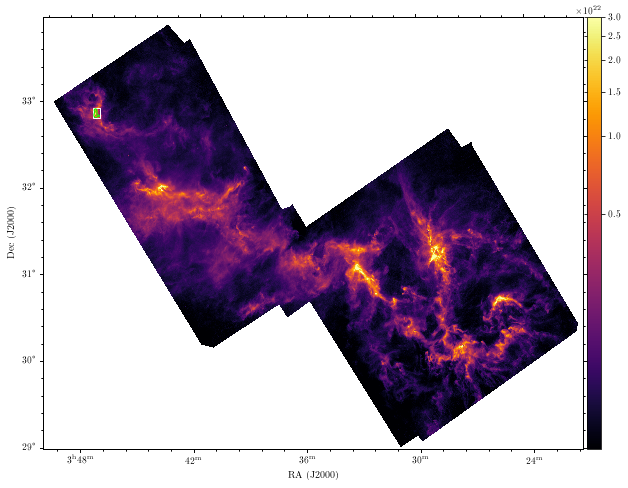

In [84]:
fig = aplpy.FITSFigure(N_H2_file)
fig.show_colorscale(vmin=5e20, vmax=3e22, cmap='inferno', stretch='arcsinh')
fig.show_rectangles(56.9032, 32.8825, 0.0861394, 0.113995, color='white')
fig.add_colorbar()
fig.show_regions(region_file)

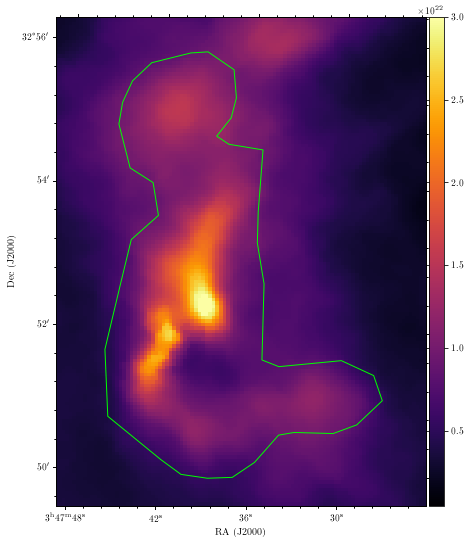

In [85]:
fig = aplpy.FITSFigure(N_H2_file)
fig.show_colorscale(vmin=5e20, vmax=3e22, cmap='inferno')
fig.recenter(56.9032, 32.8825, width=0.0861394, height=0.113995)
fig.add_colorbar()
fig.show_regions(region_file)

Here we make the cutouts on the Herschel H2 column density map, and the SCUBA2 450 and 850$\mu$m data to calculate the total flux in the region.

In [87]:
from regions import read_ds9
from astropy.wcs import WCS

regions = read_ds9(region_file)
data, hd = fits.getdata(N_H2_file, header=True)
# load region file and WCS structures
wcs_H2 = WCS(N_H2_file)
#
mask_H2 = (regions[0].to_pixel(wcs_H2)).to_mask()
H2_cutout = mask_H2.cutout(data)
H2_multiply = mask_H2.multiply(data)
H2_edge = H2_cutout - H2_multiply

In [88]:
data_850, hd_850 = fits.getdata(file_850, header=True)
# load region file and WCS structures
wcs_850 = WCS(file_850)
#
mask_850 = (regions[0].to_pixel(wcs_850)).to_mask()
data850_cutout = mask_850.cutout(np.squeeze(data_850))
data850_multiply = mask_850.multiply(np.squeeze(data_850))

Set OBSGEO-B to    19.822833 from OBSGEO-[XYZ].
Set OBSGEO-H to     4120.022 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [89]:
data_450, hd_450 = fits.getdata(file_450, header=True)
# load region file and WCS structures
wcs_450 = WCS(file_450)
#
mask_450 = (regions[0].to_pixel(wcs_450)).to_mask()
data450_cutout = mask_450.cutout(np.squeeze(data_450))
data450_multiply = mask_450.multiply(np.squeeze(data_450))

Set OBSGEO-B to    19.822833 from OBSGEO-[XYZ].
Set OBSGEO-H to     4120.022 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [90]:
data_w11, hd_w11 = fits.getdata(file_w11, header=True)
# load region file and WCS structures
wcs_w11 = WCS(file_w11)
#
mask_w11 = (regions[0].to_pixel(wcs_w11)).to_mask()
dataw11_cutout = mask_w11.cutout(np.squeeze(data_w11))
dataw11_multiply = mask_w11.multiply(np.squeeze(data_w11))

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


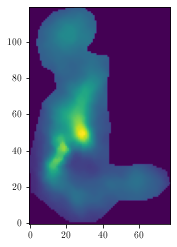

In [91]:
plt.imshow(H2_multiply, origin='lowest')

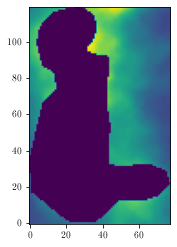

In [92]:
plt.imshow(H2_edge, origin='lowest')

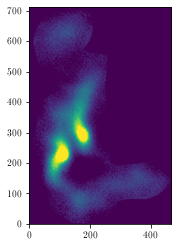

In [93]:
plt.imshow(data850_multiply, origin='lowest', vmin=0, vmax=2e-4)

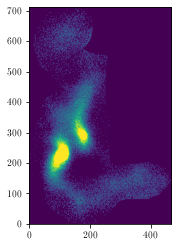

In [94]:
plt.imshow(data450_multiply, origin='lowest', vmin=0, vmax=1e-3)

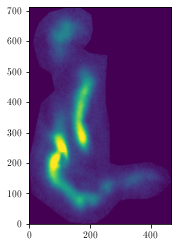

In [95]:
plt.imshow(dataw11_multiply, origin='lowest', vmin=0, vmax=0.25)

## Mass calculations

#### Herschel 

Determination of the total column density for the whole region, we also calculate the background removed column density which gives a strong lower limit. The mass is then calculated as multiplying this quantities by the pixels size and the average molecular mass weight.

In [15]:
B5_Herschel_Ntotal = H2_multiply.sum()/u.cm**2
B5_Herschel_Ntotal_bk = B5_Herschel_Ntotal - np.sum(H2_multiply != 0) * np.min(H2_multiply[H2_multiply != 0])/u.cm**2

In [16]:
B5_Herschel_Mtotal = Ncol_to_mass(Ntotal=B5_Herschel_Ntotal, distance=300*u.pc, pixsize=hd['cdelt2']*u.deg)

In [17]:
B5_Herschel_Mtotal_bk = Ncol_to_mass(Ntotal=B5_Herschel_Ntotal_bk, distance=300*u.pc, pixsize=hd['cdelt2']*u.deg)

In [18]:
print(B5_Herschel_Mtotal, B5_Herschel_Mtotal_bk)

23.173711961725516 solMass 15.574736077164678 solMass


#### Edge
Calcualting the properties for the edge

In [96]:
B5_Herschel_edge_Ntotal = H2_edge.sum()/u.cm**2
B5_Herschel_edge_Ntotal_bk = B5_Herschel_edge_Ntotal - np.sum(H2_edge != 0) * np.min(H2_edge[H2_edge != 0])/u.cm**2

In [97]:
B5_Herschel_edge_Mtotal = Ncol_to_mass(Ntotal=B5_Herschel_edge_Ntotal, distance=300*u.pc, pixsize=hd['cdelt2']*u.deg)

In [98]:
print(B5_Herschel_edge_Mtotal)

12.624440021891553 solMass


#### SCUBA-2 

In [99]:
F_850 = (data850_multiply[data850_multiply > 0]).sum()*u.Jy
F_450 = (data450_multiply[data450_multiply > 0]).sum()*u.Jy

In [100]:
print(F_450, F_850)

30.808977048885033 Jy 5.5663139696602775 Jy


In [101]:
Mass_450 = mass_dust(kappa_nu=kappa_Her_450, distance=d_per, wavelength=my_wavelength, Flux=F_450)
Mass_850 = mass_dust(kappa_nu=kappa_Her_850, distance=d_per, wavelength=my_wavelength2, Flux=F_850)

In [102]:
print(Mass_450, Mass_850)

16.25384225773659 solMass 13.339917276900035 solMass


### Density determination 

Since we have a mass deterination, then we calculate the density if we have a radius estimate. 
The region equivalent radius is determined as $\pi R_{eq}^2 = Area = A_{pixel} N_{pixel}$.

In [103]:
region_area = np.sum(H2_multiply != 0)*((hd['cdelt2']*u.deg).to('', equivalencies=u.dimensionless_angles())*300*u.pc)**2

In [104]:
region_radius = np.sqrt(region_area / np.pi)

In [105]:
print(region_radius)

0.16925255797936847 pc


For the edge, we calculate the redius of the outer region, and then calculate the density using the radius with the equivalent volume.
$$
\pi (R_{out}^2 - R_{eq}^2) = Area
$$
and then
$$
R_{edge,eq} = (R_{out}^3 - R_{eq}^3)^{1/3}
$$


In [106]:
region_edge_area = np.sum(H2_edge != 0)*((hd['cdelt2']*u.deg).to('', equivalencies=u.dimensionless_angles())*300*u.pc)**2

In [107]:
region_edge_radius = np.sqrt((region_area / np.pi + region_radius**2))
region_edge_radius_eq = np.power(region_edge_radius**3 - region_radius**3, 1/3.)

In [109]:
print(region_edge_radius, region_edge_radius_eq)

0.2393592629607615 pc 0.20696383326918213 pc


In [114]:
density(B5_Herschel_Mtotal, region_radius)

<Quantity 1.66091887 10000 / cm3>

In [115]:
density(B5_Herschel_edge_Mtotal, region_edge_radius_eq)

<Quantity 0.49486562 10000 / cm3>

In [116]:
density(B5_Herschel_Mtotal_bk, region_radius)

<Quantity 1.11628094 10000 / cm3>

In [117]:
density(Mass_850, region_radius)

<Quantity 0.95610579 10000 / cm3>

In [118]:
density(Mass_450, region_radius)

<Quantity 1.16495421 10000 / cm3>

In [119]:
F_w11 = (dataw11_multiply[dataw11_multiply > 0]).sum()

In [120]:
F_w11_bk = (dataw11_multiply[dataw11_multiply > 0] - np.min(dataw11_multiply[dataw11_multiply > 0])).sum()

In [121]:
F_w11, F_w11_bk

(9514.651869848789, 9510.365948606854)

In [122]:
conv_beam2pix= (1./(2*np.pi/(8*np.log(2))*hd_w11['BMAJ']*hd_w11['BMIN']) * (hd_w11['CDELT1'])**2)

In [123]:
F_w11 * conv_beam2pix

58.313081265198115

In [124]:
param, hd_fit = fits.getdata('fit_files/B5_NH3_thin_fittedParameters_snr8.fits', header=True)

In [125]:
file_fit = 'fit_files/B5_NH3_thin_fittedParameters_snr8.fits'
data_fit, hd_fit = fits.getdata(file_fit, header=True)
# load region file and WCS structures
wcs_fit = WCS(file_fit)
#
mask_fit = (regions[0].to_pixel(wcs_fit)).to_mask()
datafit_cutout = mask_fit.cutout(np.squeeze(data_fit[2,:,:]))
datafit_multiply = mask_fit.multiply(np.squeeze(data_fit[2,:,:]))

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


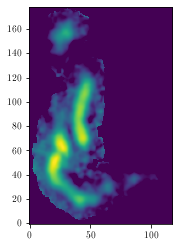

In [126]:
plt.imshow(datafit_multiply, origin='lowest', vmin=14, vmax=15)

In [127]:
N_NH3 = 10**(datafit_multiply+8.5)
N_NH3_tot = (N_NH3[datafit_multiply != 0] - np.min(N_NH3[datafit_multiply != 0])).sum() / u.cm**2

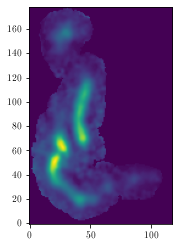

In [128]:
plt.imshow(N_NH3, origin='lowest')

In [129]:
M_NH3_bk = Ncol_to_mass(Ntotal=N_NH3_tot, distance=d_per, pixsize=hd_fit['cdelt2']*u.deg)
print(M_NH3_bk)

104.324905067506 solMass


In [130]:
def Jeans_length(T=10*u.K, density=1e4/u.cm**3):
    """
    """
    return (44.3e3*u.au * np.sqrt(T/(10*u.K)) * np.sqrt(1e4/u.cm**3 / density)).to(u.au)

In [131]:
Jeans_length(density=density(B5_Herschel_Mtotal, region_radius))

<Quantity 34373.9560406 AU>

In [132]:
Jeans_length(density=density(M_NH3_bk, region_radius))

<Quantity 16200.68285845 AU>

In [133]:
region_radius

<Quantity 0.16925256 pc>

In [134]:
density(M_NH3_bk, region_radius)

<Quantity 7.47723124 10000 / cm3>

In [46]:
density(B5_Herschel_Mtotal, region_radius)

<Quantity 1.66091887 10000 / cm3>

In [72]:
H2_cutout_masked = H2_cutout - H2_multiply

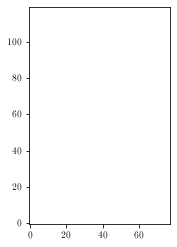

In [73]:
plt.imshow(H2_cutout_masked, origin='lowest')

In [49]:
B5_Herschel_Ntotal_full = H2_cutout.sum()/u.cm**2
B5_Herschel_Mtotal_full = Ncol_to_mass(Ntotal=B5_Herschel_Ntotal_full, distance=300*u.pc, pixsize=hd['cdelt2']*u.deg)

In [50]:
print(B5_Herschel_Mtotal_full)

35.79815170097168 solMass


In [53]:
region_area_full = np.sum(H2_cutout != 0)*((hd['cdelt2']*u.deg).to('', equivalencies=u.dimensionless_angles())*300*u.pc)**2
region_radius_full = np.sqrt(region_area_full / np.pi)

In [54]:
region_radius_full

<Quantity 0.23816633 pc>

In [55]:
density(B5_Herschel_Mtotal_full, region_radius)

<Quantity 0.92082701 10000 / cm3>

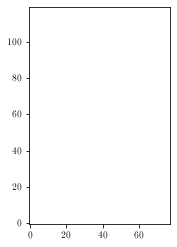

In [79]:
plt.imshow( (H2_cutout_masked), origin='lowest')

In [74]:
H2_cutout_masked[0,0]

nan

In [78]:
H2_multiply[0,0]

0.0